# Predicting NBA players salary with Neural Networks coded from scratch (CODE)
###By Nicolas García and Carlos Villa

In [ ]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.metrics import r2_score
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px


Our goal is to predict the salary of NBA players based on different statistics. First we clean the dataset to be able to use it.

In [ ]:
pd.set_option('display.max_columns', 75)
nbaData="NBAdata.csv"
temp=pd.read_csv(nbaData)
stats=temp.copy()
stats=stats.drop("#", axis=1)
stats=stats.drop("blank2", axis=1)
stats=stats.drop("blanl", axis=1)

stats.rename(columns={"Season Start": "Season"}, inplace=True)
stats.rename(columns={"Tm": "Team"}, inplace=True)
stats.rename(columns={"Player Name": "Name"}, inplace=True)
stats.rename(columns={"Player Salary in $": "Salary"}, inplace=True)
stats.rename(columns={"G": "GP"}, inplace=True)

#mapping numeric values onto positions
mapping = {'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C':5}
stats['Pos'] = stats['Pos'].map(mapping)

#ratio of Games started to games played
stats["GS/GP"]=stats["GS"]/stats["GP"]

#removing last row from dataset because it's null
stats=stats[:-1]

#stats should be a on a per-game basis instead of totals to eliminate the effect of games played
stats["MPG"]=stats["MP"]/stats["GP"]
stats["ORPG"]=stats["ORB"]/stats["GP"]
stats["DRPG"]=stats["DRB"]/stats["GP"]
stats["RPG"]=stats["TRB"]/stats["GP"]
stats["APG"]=stats["AST"]/stats["GP"]
stats["SPG"]=stats["STL"]/stats["GP"]
stats["BPG"]=stats["BLK"]/stats["GP"]
stats["TPG"]=stats["TOV"]/stats["GP"]
stats["PFPG"]=stats["PF"]/stats["GP"]
stats["PPG"]=stats["PTS"]/stats["GP"]
stats["FGPG"]=stats["FG"]/stats["GP"]
stats["FGAPG"]=stats["FGA"]/stats["GP"]
stats["3PPG"]=stats["3P"]/stats["GP"]
stats["3PAPG"]=stats["3PA"]/stats["GP"]
stats["2PPG"]=stats["2P"]/stats["GP"]
stats["2PAPG"]=stats["2PA"]/stats["GP"]
stats["FTPG"]=stats["FT"]/stats["GP"]
stats["FTAPG"]=stats["FTA"]/stats["GP"]

#drop all total columns
drop_column = ['MP', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA']
stats.drop(drop_column, axis=1, inplace = True)

#change salary from object to float
stats["Salary"] = stats.Salary.astype(float)

#removed stars from some players names
stats['Name'] = stats['Name'].map(lambda x: x.rstrip('*'))

#dataset had total stats for a player if he was on two teams in one season, but we wanted to look at data on specific teams, too, so the "TOT" value wouldn't work
stats=stats[~stats["Team"].str.contains("TOT", na=False)]

#players don't qualify if they've played in less than or equal to 15 games on a team
stats=stats[stats['GP']>15]

#if no salary is in the dataset, we can't use that row
stats=stats.dropna(subset = ['Salary'])


#if a player still had a NaN at this point, it meant they didn't take any shots that season, so give them values of 0s for the percentages columns
empty=['TS%','3PAr','FTr','TOV%','FG%','3P%','2P%','eFG%','FT%']
for i in empty:
    stats[i].fillna(0, inplace=True)

#teams have changed names and locations over the years, this is keeping the names consistent
stats["Team"].replace("CHH", "NOP", inplace=True)
stats["Team"].replace("NOH", "NOP", inplace=True)
stats["Team"].replace("NOK", "NOP", inplace=True)
stats["Team"].replace("NJN", "BRK", inplace=True)
stats["Team"].replace("WSB", "WAS", inplace=True)
stats["Team"].replace("SEA", "OKC", inplace=True)
stats["Team"].replace("VAN", "MEM", inplace=True)
stats["Team"].replace("CHA", "CHO", inplace=True)
len(stats["Team"].unique())


30

This is what our dataset looks like now

In [ ]:
stats.head()

,Season,Name,Salary,Pos,Age,Team,GP,GS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,3P%,2P%,eFG%,FT%,GS/GP,MPG,ORPG,DRPG,RPG,APG,SPG,BPG,TPG,PFPG,PPG,FGPG,FGAPG,3PPG,3PAPG,2PPG,2PAPG,FTPG,FTAPG
0,1995.0,A.C. Green,6473000.0,3.0,31.0,PHO,82.0,52.0,14.2,0.596,0.206,0.556,8.3,20.4,14.3,6.5,1.0,0.8,12.9,14.2,4.6,2.1,6.7,0.120,0.6,0.2,0.7,1.9,0.504,0.339,0.547,0.539,0.732,0.634146,32.768293,2.365854,5.792683,8.158537,1.548780,0.670732,0.378049,1.390244,1.780488,11.170732,3.792683,7.524390,0.524390,1.548780,3.268293,5.975610,3.060976,4.182927
1,1995.0,Aaron McKie,845000.0,2.0,22.0,POR,45.0,20.0,13.3,0.500,0.107,0.280,4.6,13.5,8.8,15.9,2.2,1.4,11.7,17.0,0.8,1.2,2.0,0.115,-1.2,1.3,0.1,0.4,0.444,0.393,0.451,0.466,0.685,0.444444,18.377778,0.777778,2.088889,2.866667,1.977778,0.800000,0.355556,0.866667,2.155556,6.511111,2.577778,5.800000,0.244444,0.622222,2.333333,5.177778,1.111111,1.622222
4,1995.0,Acie Earl,1040000.0,5.0,24.0,BOS,30.0,3.0,6.6,0.409,0.000,0.426,10.4,14.6,12.5,1.4,1.5,2.6,14.8,19.7,-0.4,0.2,-0.2,-0.038,-6.8,-1.9,-8.7,-0.4,0.382,0.000,0.382,0.382,0.483,0.100000,6.933333,0.633333,0.866667,1.500000,0.066667,0.200000,0.266667,0.466667,1.300000,2.200000,0.866667,2.266667,0.000000,0.000000,0.866667,2.266667,0.466667,0.966667
5,1995.0,Adam Keefe,1650000.0,3.0,24.0,UTA,75.0,0.0,15.1,0.616,0.000,0.581,14.0,18.0,16.1,3.5,1.5,1.6,14.2,15.6,2.4,1.7,4.1,0.154,0.6,0.2,0.8,0.9,0.577,0.000,0.577,0.577,0.676,0.000000,16.933333,1.800000,2.560000,4.360000,0.400000,0.480000,0.333333,0.826667,1.880000,6.146667,2.293333,3.973333,0.000000,0.000000,2.293333,3.973333,1.560000,2.306667
11,1995.0,Alonzo Mourning,4560000.0,5.0,24.0,NOP,77.0,77.0,20.1,0.593,0.031,0.585,8.4,21.6,15.3,6.6,0.9,5.5,14.8,25.6,4.3,5.1,9.4,0.153,-0.8,2.1,1.3,2.5,0.519,0.324,0.525,0.524,0.761,1.000000,38.194805,2.597403,7.285714,9.883117,1.441558,0.636364,2.922078,3.129870,3.571429,21.337662,7.415584,14.298701,0.142857,0.441558,7.272727,13.857143,6.363636,8.363636


Now we convert the variables "Season" into numerical values as 1,2,3...etc and later we convert the variable "Team" into numerical values but now the number 1 is for the team which has the biggest average of salaries, the number 2 for the second... etc.

In [ ]:
stats['Season_list']=stats['Season']-1994.0
stats = stats.drop('Season', axis=1)
stats['team_numeric'] = pd.factorize(stats['Team'])[0] + 1
stats = stats.drop('Team',axis=1)
mean_salary_by_group = stats.groupby('team_numeric')['Salary'].mean()
# ranks the teams in ascending order according to their average salaries
teams_ordered = mean_salary_by_group.sort_values().index
# Now create the column "team by order" and assigns the numerical values
stats['team by order'] = stats['team_numeric'].map({team: i+1 for i, team in enumerate(teams_ordered)})
stats = stats.drop('team_numeric',axis=1)

In [ ]:
x = stats.drop('Salary',axis=1)
y = stats['Salary']

Now we have separated the data set into the variable x which is the matrix with 7682 players and each with 51 features and the variable y which is the salary of each player.

Now we normalise the data, dropping the variable "Name" because it's not important for our study.

In [ ]:
x_without_names = x.drop('Name',axis=1)
scaler = MinMaxScaler()
normalized_x = pd.DataFrame(scaler.fit_transform(x_without_names), columns=x_without_names.columns)

In order not to have very large numbers, we consider the salary in millions.

In [ ]:
y = np.array(y)
y = y/1000000 # we prefer to have the salaries in millions
y = y.reshape((7682,1))
normalized_x = np.array(normalized_x)

Now we divide our data set into trainning and test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(normalized_x, y, test_size=0.2, random_state=42)

We build two different classes.

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))
def relu(x):
  return np.maximum(0,x)
  
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / (input_size + hidden_size))  # Glorot initialization
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / (hidden_size + output_size))  
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)  # sigmoid. Can be changed to relu by changing also the corresponding line in the backward method
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.y_hat = relu(self.z2) # relu

    def backward(self, X, y,lr):
        m = X.shape[0]
        dL_dy_hat = 2 * (self.y_hat - y) / m
        dL_dz2 = dL_dy_hat * (self.z2>0)
        dL_dW2 = np.dot(self.a1.T, dL_dz2)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        dL_da1 = np.dot(dL_dz2, self.W2.T)
        #dL_dz1 = dL_da1 * (self.a1 > 0)  # derivative of ReLU activation function 
        dL_dz1 = dL_da1 * (1-self.a1)*self.a1  # derivative sigmoid
        dL_dW1 = np.dot(X.T, dL_dz1)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        # update parameters
        self.W2 -= lr * dL_dW2  
        self.b2 -= lr * dL_db2
        self.W1 -= lr * dL_dW1
        self.b1 -= lr * dL_db1

    def train(self, X, y, epochs, x_test,y_test,imp,lr=0.01,plot=0):      
        losses1 = []
        losses2=[]
        epoch=range(epochs)
        for i in range(epochs):                                                                                  
            self.forward(X)
            self.backward(X, y, lr)                  
            loss = np.mean((self.predict(X) - y) ** 2)
            losses1.append(loss)
            losses2.append(np.mean((self.predict(x_test)-y_test) ** 2))

            if (i+1) % int(epochs/imp) == 0:
              print("Epoch", i+1, "with loss =", loss)
              print("loss on test: ", np.mean((self.predict(x_test)-y_test) ** 2) )

        if plot==1:
          plt.plot(epoch, losses1, color='red', label='trainning error')
          plt.plot(epoch, losses2, color='blue', label='test error')
          plt.xlabel('Epochs')
          plt.ylabel('Error')
          plt.title('Error tests')
           
    def predict(self, X):
        self.forward(X)
        return self.y_hat

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))
def relu(x):
  return np.maximum(0,x)

class NeuralNetwork2:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / (input_size + hidden_size))  # Glorot initialization
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / (hidden_size + output_size)) 
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)  # sigmoid
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.y_hat = relu(self.z2) # relu

    def create_minibatches(self, mb_size, x, y, shuffle = True):       
        assert x.shape[0] == y.shape[0], 'Error in number of samples' 
        total_data = x.shape[0]
        if shuffle: 
            idxs = np.arange(total_data) 
            np.random.shuffle(idxs) 
            x = x[idxs] 
            y = y[idxs]

        return ([(x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size)]) 
    

    def backward(self, X, y,lr,reg,reg_lambda):
        m = X.shape[0]
        dL_dy_hat = 2 * (self.y_hat - y) / m
        dL_dz2 = dL_dy_hat * (self.z2>0)
        dL_dW2 = np.dot(self.a1.T, dL_dz2)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        dL_da1 = np.dot(dL_dz2, self.W2.T)
        #dL_dz1 = dL_da1 * (self.a1 > 0)  # derivative of ReLU activation function 
        dL_dz1 = dL_da1 * (1-self.a1)*self.a1  # derivative sigmoid
        dL_dW1 = np.dot(X.T, dL_dz1)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        if reg==1:
          dL_dW2 += reg_lambda * np.sign(self.W2)
          dL_dW1 += reg_lambda * np.sign(self.W1)
        elif reg==2:
          dL_dW2 += reg_lambda * (self.W2)
          dL_dW1 += reg_lambda * (self.W1)
        else:
          dL_dW2=dL_dW2
          dL_dW1=dL_dW1
        # update parameters
        self.W2 -= lr * dL_dW2  
        self.b2 -= lr * dL_db2
        self.W1 -= lr * dL_dW1
        self.b1 -= lr * dL_db1

    def train(self, X, y, epochs, x_test,y_test,imp,lr=0.01,mb_size=0,reg_lambda=0, reg=0,plot=0):
        if mb_size==0:
          mb_size = X.shape[0]
        mbs = self.create_minibatches(mb_size, X, y)        
        losses1 = []
        losses2=[]
        epoch=range(epochs)
        for i in range(epochs):            
                
            for (minibatch_x, minibatch_y) in mbs:                                                                           
                self.forward(minibatch_x)
                self.backward(minibatch_x, minibatch_y, lr, reg, reg_lambda)  
                
            loss = np.mean((self.predict(X) - y) ** 2)
            losses1.append(loss)
            losses2.append(np.mean((self.predict(x_test)-y_test) ** 2))

            if (i+1) % int(epochs/imp) == 0:
              print("Epoch", i+1, "with loss =", loss)
              print("loss on test: ", np.mean((self.predict(x_test)-y_test) ** 2) )

        if plot==1:
          plt.plot(epoch, losses1, color='red', label='trainning error')
          plt.plot(epoch, losses2, color='blue', label='test error')
          plt.xlabel('Epochs')
          plt.ylabel('Error')
          plt.title('Error tests')
           
    def predict(self, X):
        self.forward(X)
        return self.y_hat

In [ ]:
nn = NeuralNetwork2(50,20,1)
epochs = 6000
imp = 30
lrate = 0.005
batchsize = 32
nn.train(x_train,y_train,epochs,x_test,y_test,imp,lr=lrate,mb_size=batchsize,reg=2,reg_lambda=0.001,plot=1)

Now we run a linear regression model and calculate its mean square error to see if it is better than doing a neural network.

In [ ]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
predictions=linreg.predict(x_test)
print('loss: ',np.mean((predictions-y_test)**2))

loss:  10.837802977498422


We now perform a study of the features with the aim of improving our linear regression model.

[]

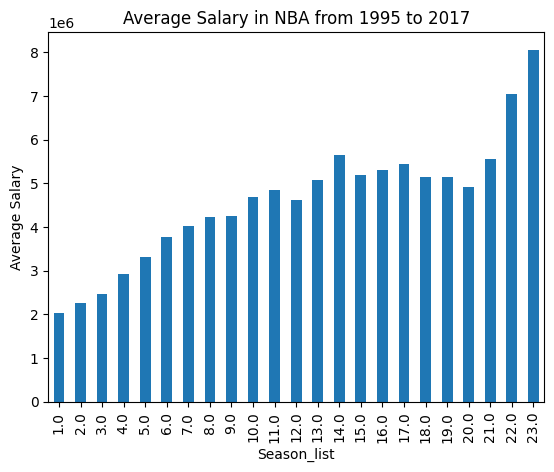

In [ ]:
fig = px.box(stats, x='team by order', y = 'Salary', color = 'team by order')
fig.update_traces(showlegend=False)
fig.show()
fig = px.box(stats, x="Pos", y = 'Salary', color = "Pos")
fig.update_traces(showlegend=False)
fig.show()
sal=stats.groupby('Season_list')['Salary'].mean()
var=sal.plot.bar(x='Season_list', y='Salary')
var.set_ylabel("Average Salary")
var.set_title("Average Salary in NBA from 1995 to 2017")
var.plot()

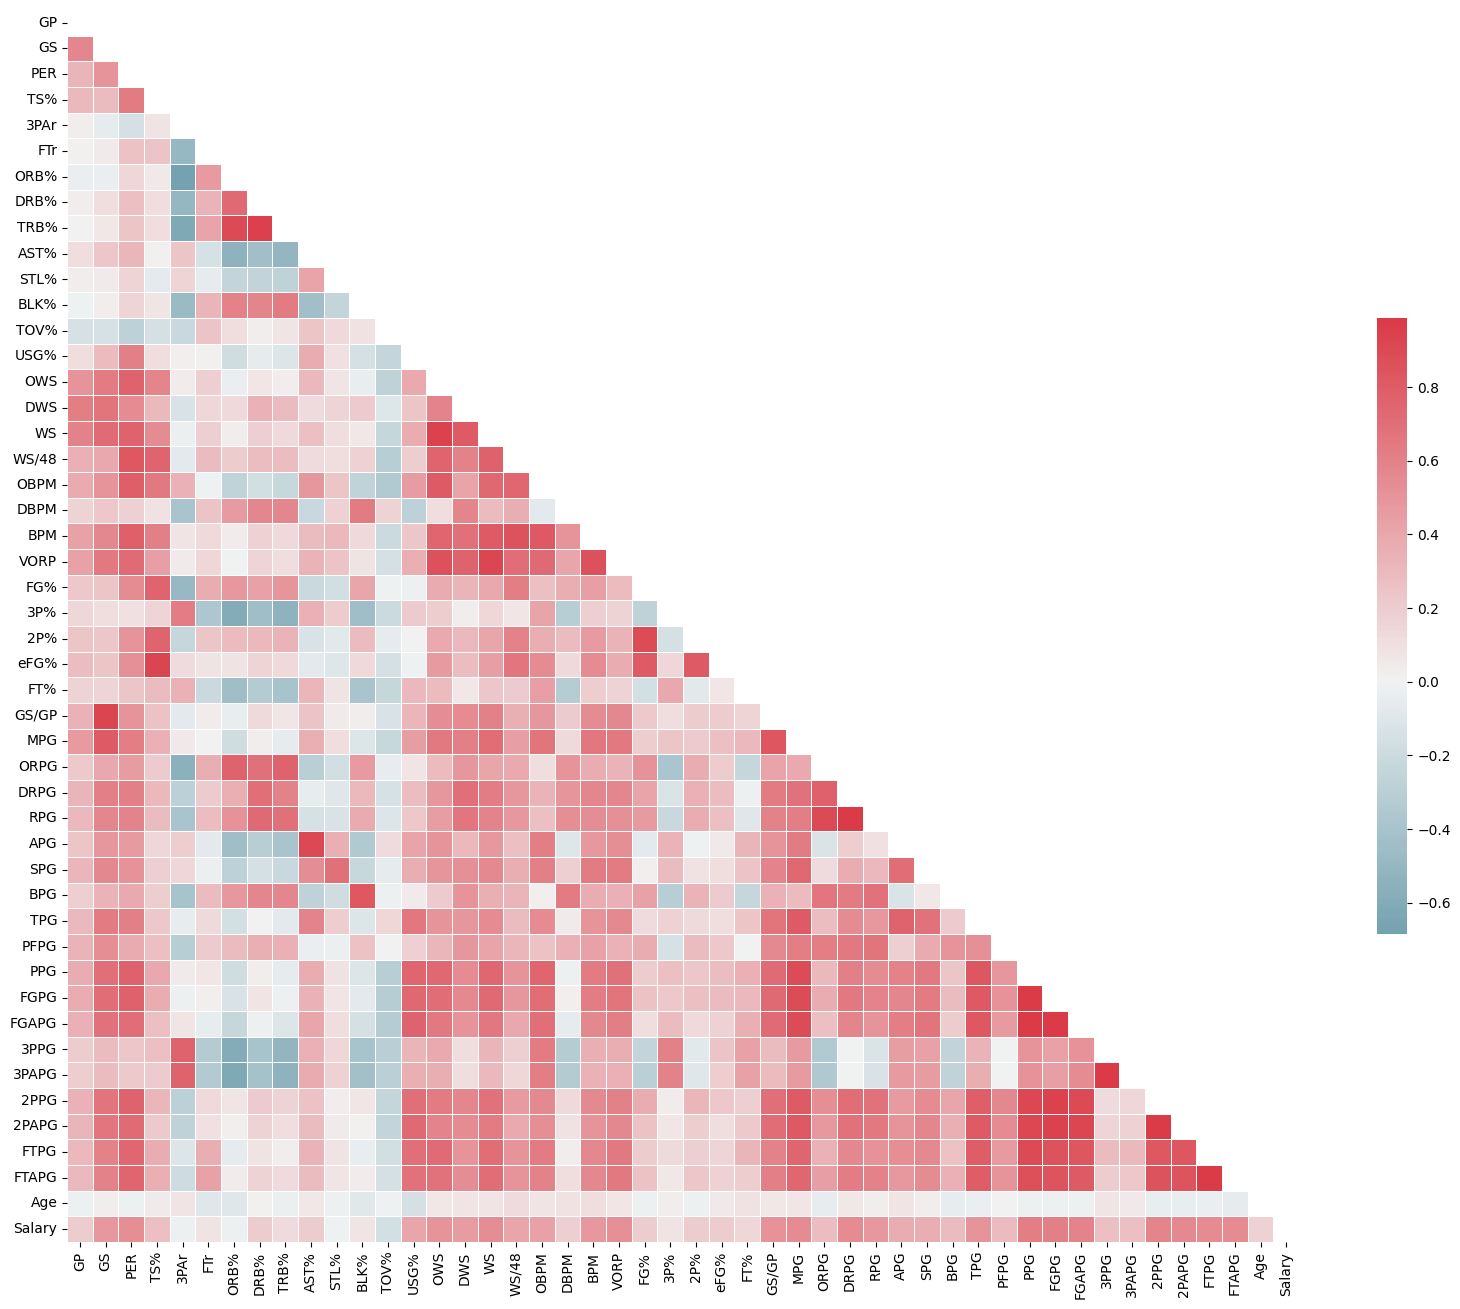

In [ ]:

cor_matrix =stats.loc[:, ['GP', 'GS', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG%', '3P%',
       '2P%', 'eFG%', 'FT%', 'GS/GP', 'MPG', 'ORPG', 'DRPG', 'RPG', 'APG',
       'SPG', 'BPG', 'TPG', 'PFPG', 'PPG', 'FGPG', 'FGAPG', '3PPG', '3PAPG',
       '2PPG', '2PAPG', 'FTPG', 'FTAPG','Age', 'Salary']].corr()
mask = np.triu(np.ones_like(cor_matrix, dtype = np.bool))
plt.figure(figsize = (20, 16))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(cor_matrix, mask = mask, cmap = cmap, center = 0,square = True, linewidths = .5, cbar_kws = {"shrink": .5})
sns.set(style = "white")


In [ ]:
columns = []
for column in cor_matrix.columns:   
    correlation = abs(cor_matrix['Salary'][column])
    if correlation < 0.15:
        # Prints column name and correlation value
        print(f"Variable: {column} | correlation: {correlation}")
        columns.append(column)
print(columns)

Variable: 3PAr | correlation: 0.024506237079224755
Variable: FTr | correlation: 0.08088640067656529
Variable: ORB% | correlation: 0.021980171138718585
Variable: TRB% | correlation: 0.12475505746318273
Variable: STL% | correlation: 0.01111957319491591
Variable: BLK% | correlation: 0.071677537514299
Variable: 3P% | correlation: 0.0834300651935997
Variable: FT% | correlation: 0.14624856512276857
['3PAr', 'FTr', 'ORB%', 'TRB%', 'STL%', 'BLK%', '3P%', 'FT%']


In [ ]:
x = x.drop(columns,axis=1)

In [ ]:
print(x.shape)

(7682, 43)


In [ ]:
# Normalize the dataframe x
x_sin_nombres = x.drop('Name',axis=1)
scaler = MinMaxScaler()
normalized_x = pd.DataFrame(scaler.fit_transform(x_sin_nombres), columns=x_sin_nombres.columns)
normalized_x = np.array(normalized_x)
x_train, x_test, y_train, y_test = train_test_split(normalized_x, y, test_size=0.2, random_state=42)

loss  10.821280212182872
R sq is : 0.5704037674952478


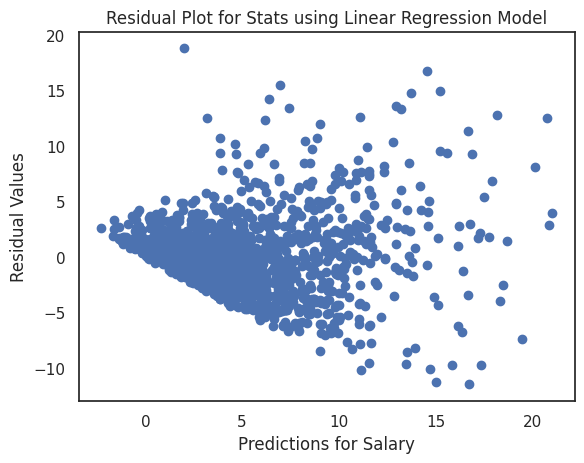

In [ ]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
predictions=linreg.predict(x_test)
print('loss ',np.mean((predictions-y_test)**2))
score = metrics.r2_score(y_test, predictions)
print ('R sq is :', score)
#create residual plot
residuals = y_test - predictions
plt.scatter(predictions, residuals)
#plt.scatter(predictions, y_test- linreg.predict(x_test))
plt.xlabel('Predictions for Salary')
plt.ylabel('Residual Values')
plt.title('Residual Plot for Stats using Linear Regression Model')
plt.show()

We can also plot the residuals of the neural network prediction:

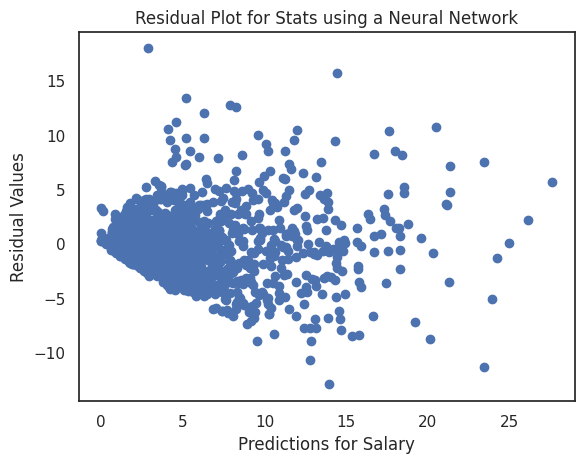

In [ ]:

NNresiduals = y_test-nn.predict(x_test)
plt.scatter(nn.predict(x_test), NNresiduals)
plt.xlabel('Predictions for Salary')
plt.ylabel('Residual Values')
plt.title('Residual Plot for Stats using a Neural Network')
plt.show()